In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import os

import config
import utils

(348, 4) 0.3 35.0
(348, 4) 0.3 35.0


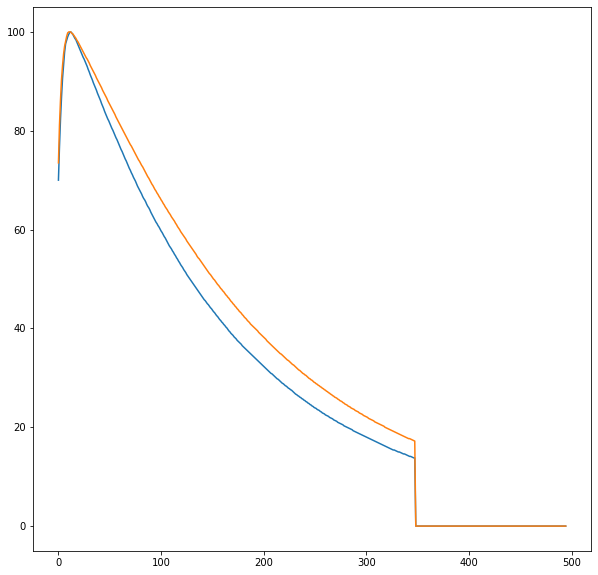

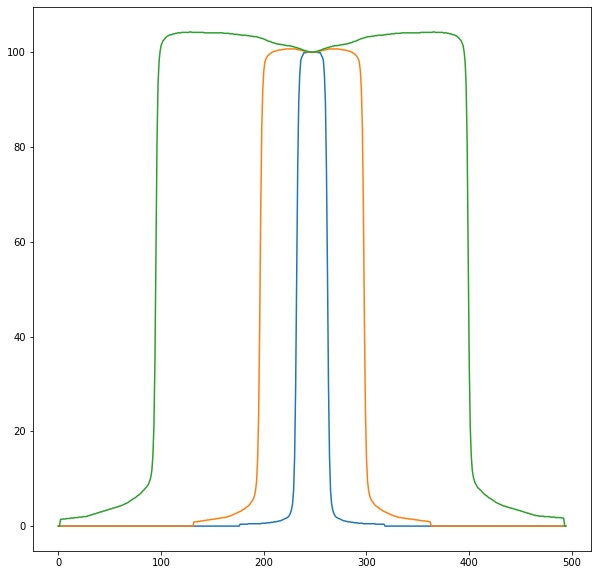

In [2]:
# Read measured profiles

measuredDoseFiles = ['./Measured/Method1/030x030_PDD.dat','./Measured/Method1/100x100_PDD.dat']#,'./Measured/Method1/300x300_PDD.dat']

plt.figure(figsize=(10,10))
clinicalProfiles = []
dum = []
for f, measuredDoseFile in enumerate(measuredDoseFiles):
    measuredDose = utils.readMeasuredDoseFile(measuredDoseFile)[3:,:]
    print(measuredDose.shape,measuredDose[0,2],measuredDose[measuredDose.shape[0]-1,2])
    
    profile = np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
    np.copyto(profile[config.analyzedRanges[f][0][0]:config.analyzedRanges[f][0][1]],measuredDose[:,3])
    dum.append(profile)
    plt.plot(profile)
plt.show()

measuredDoseFiles = ['./Measured/Method1/030x030_PROF.dat','./Measured/Method1/100x100_PROF.dat']#,'./Measured/Method1/300x300_PROF.dat']

plt.figure(figsize=(10,10))
for f,measuredDoseFile in enumerate(measuredDoseFiles):
    measuredDose = utils.readMeasuredDoseFile(measuredDoseFile)

    profile = np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
    np.copyto(profile[config.analyzedRanges[f][1][0]:config.analyzedRanges[f][1][1]],measuredDose[:,3])
    plt.plot(profile)
    dum.append(profile)

measuredDose = utils.readMeasuredDoseFile('./Measured/Method1/300x300_PROF.dat')
profile = np.zeros(config.numOfSimulatedProfileSamples,dtype=np.float)
np.copyto(profile[config.analyzedRanges[2][0][0]:config.analyzedRanges[2][0][1]],measuredDose[:,3])
dum.append(profile)
plt.plot(profile)
plt.show()

clinicalProfiles.append(dum[0])
clinicalProfiles.append(dum[2])
clinicalProfiles.append(dum[1])
clinicalProfiles.append(dum[3])
clinicalProfiles.append(dum[4])



In [3]:

means = np.load(config.modelDIR + config.meansFileName)
print(means.shape,clinicalProfiles[0].shape)      #(3, 6, 487) (487,)

diffTest = np.zeros((3,1,2,config.numOfSimulatedProfileSamples),dtype=np.float)

#Field 3
diff = clinicalProfiles[0] - means[0,0]
np.copyto(diffTest[0,0,0,:],diff)
diff = clinicalProfiles[1] - means[0,1]
np.copyto(diffTest[0,0,1,:],diff)

#Field 10
diff = clinicalProfiles[2] - means[1,0]
np.copyto(diffTest[1,0,0,:],diff)
diff = clinicalProfiles[3] - means[1,1]
np.copyto(diffTest[1,0,1,:],diff)

#Field 30
#diff = clinicalProfiles[4] - means[2,0]
#np.copyto(diffTest[2,0,0,:],diff)
diff = clinicalProfiles[4] - means[2,1]
np.copyto(diffTest[2,0,1,:],diff)

print(diffTest.shape)


(3, 6, 495) (495,)
(3, 1, 2, 495)


In [4]:
from sklearn.decomposition import PCA
import pickle


testFeatures = []

for nfield,(field,Ranges) in enumerate(zip(config.analyzedProfiles,config.analyzedRanges)):
    if field != None:
        for profile,Range in zip(field,Ranges):
            print(nfield,profile)
            pcaName = config.modelDIR + 'PCA_' + str(nfield) + '_' + str(profile) + '_.pkl'
            pca = pickle.load(open(pcaName,'rb'))

            X = diffTest[nfield][:,profile,Range[0]:Range[1]]
            X_projected = pca.transform(X)
            testFeatures.append(X_projected)

X_test = np.stack(testFeatures)
X_test = np.swapaxes(X_test,1,0)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))  
print(X_test.shape)


0 0
0 1
1 0
1 1
2 1
(1, 15)


In [5]:
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV


preds = []
for goal in config.trainingGoals:
    modelName = config.modelDIR + 'SVR_' + str(goal) + '_.pkl'
    clf = pickle.load(open(modelName,'rb'))
    predTest = clf.predict(X_test)
    preds.append(predTest[0])
    
print(preds)

[5.53911976124087, 0.5, -0.13714949088413286, 1.9728098586454137]


In [6]:
allMeans,allFieldFeatures,allFieldPCAModels = utils.allPCAResults()

In [7]:
recons = utils.reconstruct(preds,allMeans,allFieldFeatures,allFieldPCAModels)
print(preds)
print(utils.difference(preds,clinicalProfiles,allMeans,allFieldFeatures,allFieldPCAModels))   


[5.53911976124087, 0.5, -0.13714949088413286, 1.9728098586454137]
5748.74199140378


In [9]:
# Optimize solution
# https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html
# https://scipy-lectures.org/advanced/mathematical_optimization/auto_examples/plot_non_bounds_constraints.html

import scipy.optimize as opt
from scipy.optimize import SR1

#preds = [6.02, 0.5, 0.0, 2.35]    #DeepBeam

def fun(cP,aM,aF,aPCA):
    def diff(y):
        return utils.difference(y,cP,aM,aF,aPCA)
    return diff

difference = fun(clinicalProfiles,allMeans,allFieldFeatures,allFieldPCAModels)

res = opt.minimize(difference, preds, method='SLSQP', jac="2-point",
               options={'ftol': 1e-10, 'disp': True},
               bounds=config.bounds)
print(res.x)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5237.565660631497
            Iterations: 14
            Function evaluations: 61
            Gradient evaluations: 10
[5.85836470e+00 5.00000000e-01 7.64286577e-08 2.44214791e+00]


In [12]:

recons = utils.reconstruct(res.x,allMeans,allFieldFeatures,allFieldPCAModels)


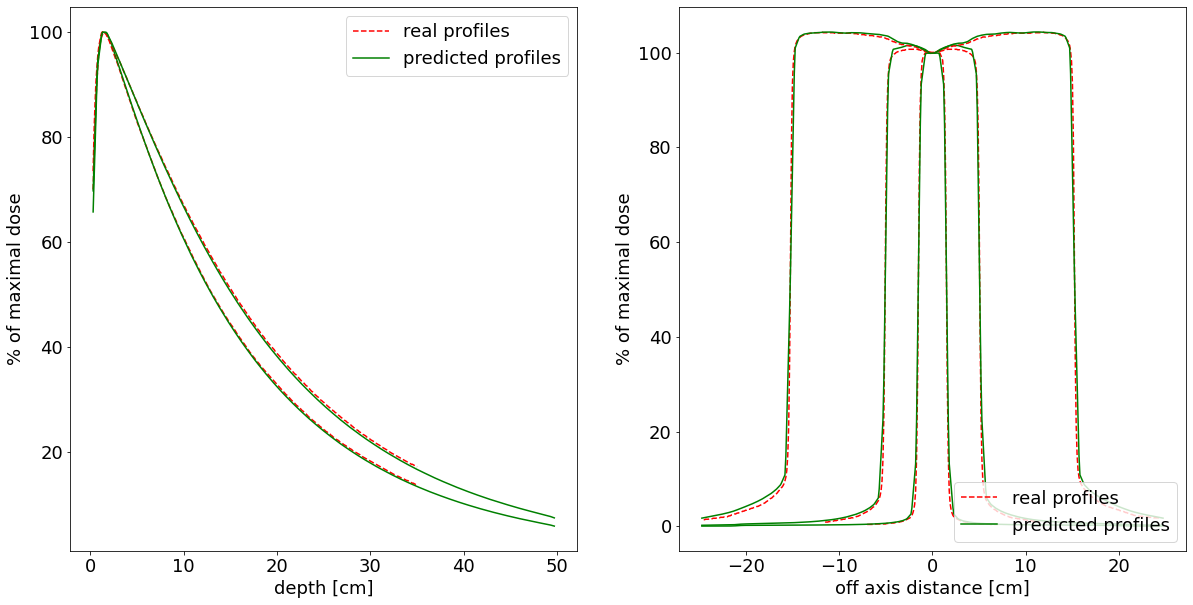

In [13]:
plt.rcParams.update({'font.size': 18})

fig, (axs1,axs2) = plt.subplots(1, 2,figsize = (20,10))

for n in [0,2]:
    if n==0:
        axs1.plot(np.arange(0.3,35.05,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--',label='real profiles')
        axs1.plot(np.arange(0.3,49.75,0.1),recons[n],'g-',label='predicted profiles')
    else:
        axs1.plot(np.arange(0.3,35.05,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--')
        axs1.plot(np.arange(0.3,49.75,0.1),recons[n],'g-')

axs1.set(xlabel = 'depth [cm]',ylabel = '% of maximal dose')
axs1.legend(loc='upper right')

    
for n in [1,3,4]:
    start = config.allRanges[n][0]*0.1 -24.7
    end = config.allRanges[n][1]*0.1 - 24.7 
    if n==4:
        end = end - 0.05
    if n==1:
        axs2.plot(np.arange(start,end,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--',label='real profiles')
        axs2.plot(np.arange(-24.7,24.75,0.1),recons[n],'g-',label='predicted profiles')
    else:
        axs2.plot(np.arange(start,end,0.1),clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]],'r--')
        axs2.plot(np.arange(-24.7,24.75,0.1),recons[n],'g-')

axs2.set(xlabel = 'off axis distance [cm]',ylabel = '% of maximal dose')
axs2.legend(loc='lower right')
plt.savefig('results1')


In [17]:
for n in range(len(clinicalProfiles)):
    diff = np.abs(clinicalProfiles[n][config.allRanges[n][0]:config.allRanges[n][1]] - recons[n][config.allRanges[n][0]:config.allRanges[n][1]])
    print(diff)
    break

[4.26578796e+00 4.90599996e+00 4.44622112e+00 2.88643618e+00
 6.26646661e-01 4.98926486e-01 8.09719791e-01 1.11835844e+00
 4.27004715e-01 2.64356637e-01 4.55384319e-01 4.60798559e-02
 6.32215551e-02 1.27472456e-01 4.18172571e-01 6.00338651e-01
 5.73972223e-01 4.47599691e-01 5.21231737e-01 5.94863782e-01
 6.17514612e-01 5.89184225e-01 5.60853838e-01 5.32523451e-01
 5.04193064e-01 3.70119594e-01 3.30299990e-01 2.90480386e-01
 2.50660782e-01 3.10839652e-01 2.71234078e-01 3.31841009e-01
 2.92449465e-01 2.53057922e-01 3.13672482e-01 2.75288799e-01
 2.37912978e-01 2.00537157e-01 2.63159810e-01 2.25783988e-01
 1.96167982e-01 1.74311791e-01 2.52454073e-01 2.30597881e-01
 2.08741690e-01 2.89516294e-01 2.72924747e-01 2.56333199e-01
 2.39741651e-01 1.23151629e-01 1.12963081e-01 1.09177532e-01
 1.05391984e-01 1.60796113e-03 2.17758747e-03 2.97062978e-04
 9.03191247e-03 8.22317122e-02 7.34968627e-02 6.47620132e-02
 4.90272612e-02 2.62926067e-02 1.03564056e-01 8.08294013e-02
 5.80947468e-02 2.956386